In [ ]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from cmcrameri import cm
from PIL import Image
from huggingface_hub import hf_hub_download, login
import torch
import h5py

from mopadi.dataset import DefaultTilesDataset
from mopadi.configs.templates import tcga_crc_autoenc
from mopadi.configs.templates_cls import crc_pretrained_mil
from mopadi.mil.manipulate.manipulator_mil import ImageManipulator, compute_structural_similarity

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
patient_name = "TCGA-AD-6964-01Z-00-DX1"

In [ ]:
# for downloading pretrained MoPadi models authenticate with a Hugging Face API token
# you need to have obtained access to the MoPadi repository on Hugging Face: https://huggingface.co/KatherLab/MoPaDi
token = input("Enter your Hugging Face API token: ")
login(token=token)

# or set your Hugging Face token as an environment variable by running `export HF_TOKEN="your_token_here`
#token = os.getenv("HF_TOKEN")
#login(token=token)

In [4]:
# download model files
autoenc_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="crc_512_model/autoenc.ckpt",
)
print(f"Autoencoder's checkpoint downloaded to: {autoenc_model_path}")

clf_model_path = hf_hub_download(
    repo_id="KatherLab/MoPaDi",
    filename="crc_512_model/mil_msi_classifier.pth",
)
print(f"Classifier's checkpoint downloaded to: {clf_model_path}")

Autoencoder's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/5d8e775e24473c5d8f4c0c57fd5c865c3c2a4aab/crc_512_model/autoenc.ckpt
Classifier's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLab--MoPaDi/snapshots/5d8e775e24473c5d8f4c0c57fd5c865c3c2a4aab/crc_512_model/mil_msi_classifier.pth


In [5]:
# looks for folders in 'images/example_data' containing patches
data = DefaultTilesDataset(
    root_dirs=["../images/example_data"],
    img_size=512,
)

Calculating cohort sizes...


  0%|          | 0/1 [00:00<?, ?it/s]

Scanning ../images/example_data


100%|██████████| 1/1 [00:00<00:00, 202.35it/s]


Cohort size (total n tiles): {'../images/example_data': 9}
Cohort size (total n WSIs): {'../images/example_data': 2}


100%|██████████| 1/1 [00:00<00:00, 361.64it/s]


Number of tiles found: 9


In [6]:
# initialize image manipulator
manipulator = ImageManipulator(
    autoenc_config = tcga_crc_autoenc(),
    autoenc_path = autoenc_model_path, 
    mil_path = clf_model_path, 
    conf_cls = crc_pretrained_mil(),
    dataset=data
)

Seed set to 0


Both models loaded successfully.


In [ ]:
# load previously extracted features for all tiles of the chosen patient
with h5py.File(f"../images/example_data/{patient_name}/features.h5", "r") as hdf_file:
    if 'feats' in hdf_file:
        features = torch.from_numpy(hdf_file['feats'][:])
    elif 'features' in hdf_file:
        features = torch.from_numpy(hdf_file['features'][:])
    else:
        raise ValueError(f"Neither 'feats' nor 'features' found in {hdf_file}")

    if 'coords' in hdf_file:
        coords = hdf_file["coords"][:]
        #print(coords)
        metadata_decoded = [f"Tile_({y},{x})" for y, x in coords]

In [12]:
lvls = [0.02, 0.04, 0.06, 0.08]

# 5 top predictive tiles of the chosen patient are being manipulated and saved to disk
manipulator.manipulate_patients_images(
    patient_name=patient_name, 
    patient_features=features.unsqueeze(dim=0),
    metadata=metadata_decoded,
    save_path="images/example_crc_msi", 
    man_amps=lvls,
    patient_class="MSIH",
    target_dict={"nonMSIH": 0, "MSIH": 1},
    num_top_tiles=3,
    #filename=filename, # if one wants to manipulate a specific tile. Must be in chosen N top predictive tiles!
    manip_tiles_separately=True
)

Top 3 tiles obtained for manipulation.


Manipulating at different amplitudes:   0%|          | 0/4 [00:00<?, ?it/s]

Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 375; metadata: Tile_(22016,11776)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(22016,11776).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 462; metadata: Tile_(23040,25088)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(23040,25088).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 139; metadata: Tile_(16896,20480)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(16896,20480).jpg


Manipulating at different amplitudes:  25%|██▌       | 1/4 [04:52<14:38, 292.80s/it]

Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 375; metadata: Tile_(22016,11776)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(22016,11776).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 462; metadata: Tile_(23040,25088)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(23040,25088).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 139; metadata: Tile_(16896,20480)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(16896,20480).jpg


Manipulating at different amplitudes:  50%|█████     | 2/4 [09:45<09:46, 293.02s/it]

Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 375; metadata: Tile_(22016,11776)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(22016,11776).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 462; metadata: Tile_(23040,25088)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(23040,25088).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 139; metadata: Tile_(16896,20480)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(16896,20480).jpg


Manipulating at different amplitudes:  75%|███████▌  | 3/4 [14:39<04:53, 293.09s/it]

Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 375; metadata: Tile_(22016,11776)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(22016,11776).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 462; metadata: Tile_(23040,25088)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(23040,25088).jpg


Patient being processed: TCGA-AD-6964-01Z-00-DX1; idx: 139; metadata: Tile_(16896,20480)
Found: ../images/example_data/TCGA-AD-6964-01Z-00-DX1/Tile_(16896,20480).jpg


Manipulating at different amplitudes: 100%|██████████| 4/4 [19:32<00:00, 293.17s/it]


[{'ori_feats': tensor([[ 3.1442e-02, -2.9404e-02,  4.3093e-02, -1.2025e-01, -4.1001e-02,
            1.2576e-02,  1.5953e-01,  6.6373e-03,  3.3005e-02,  2.2484e-02,
            7.3214e-02, -1.2904e+00, -1.2469e-01, -3.3565e-02, -1.0633e+00,
           -3.3298e-02,  1.0290e-02, -1.3597e-03,  3.7761e-02, -2.6405e+00,
            1.7305e-02, -5.5206e-01,  3.4834e-02, -2.6788e+00, -3.7781e-02,
           -9.4296e-03,  1.6858e-01, -1.0244e+00, -1.2770e-01, -1.1721e-01,
            4.7688e-03, -1.1783e-02, -1.3112e+00,  6.1317e-03, -9.5226e-01,
           -6.2761e-02,  2.6704e-02, -2.8886e-02,  3.4476e-02, -4.7654e-02,
           -1.0364e-01, -2.2032e-02, -1.5161e-02,  1.7107e-02, -1.6754e+00,
            8.5707e-03,  5.5594e-02,  2.2356e-02, -1.7459e-02, -1.3480e-02,
            3.2070e-02, -2.4711e-02, -7.1355e-02, -5.7230e-02, -2.4917e-02,
            1.5264e-02, -4.8788e-02, -2.6322e+00, -3.1029e-02, -8.4319e-02,
           -1.7664e-01, -6.6298e-02,  9.6056e-02,  4.2067e-02, -9.6778e-03,

In [13]:
fnames = os.listdir("../images/example_crc_msi")
print(f"Manipulated tiles found: {fnames}")

image_name = fnames[2]
ori = Image.open(f"../images/example_crc_msi/{image_name}/{image_name}_0_original_MSIH.png")
res = []

# load results from disk
for lvl in lvls:
    u = f'{lvl:.3f}'.replace('.', ',')
    res.append(Image.open(f"../images/example_crc_msi/{image_name}/{image_name}_manip_to_nonMSIH_amp_{u}.png"))

Manipulated tiles found: ['Tile_(16896,20480)', 'Tile_(23040,25088)', 'Tile_(22016,11776)']


### Results

In [14]:
sim = []
for i in range(len(res)):
   sim.append(compute_structural_similarity(res[i], ori))

Image Similarity: 94.203%
MSE: 0.0039
MultiScale Structural Similarity: 96.905%
-----------------------------------------------
Image Similarity: 91.923%
MSE: 0.0048
MultiScale Structural Similarity: 94.679%
-----------------------------------------------
Image Similarity: 90.194%
MSE: 0.0056
MultiScale Structural Similarity: 92.820%
-----------------------------------------------
Image Similarity: 88.768%
MSE: 0.0063
MultiScale Structural Similarity: 91.346%
-----------------------------------------------


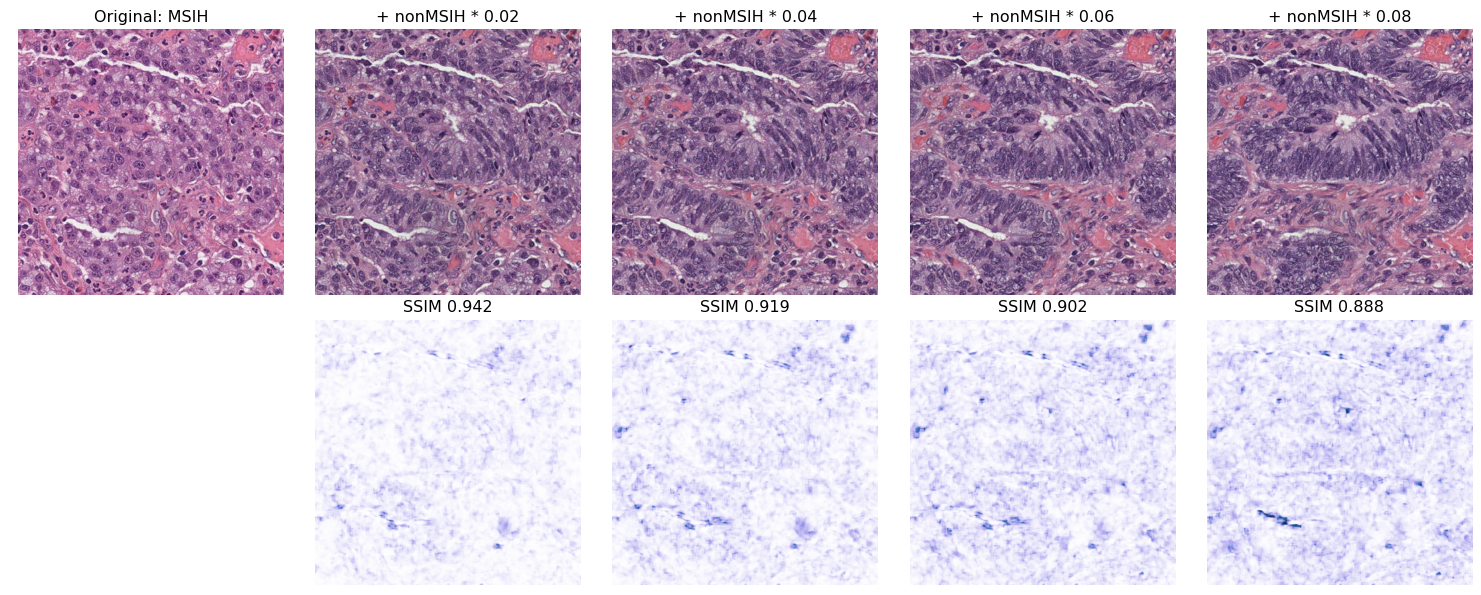

In [15]:
num_rows=2
num_cols=5

# scale all difference images for direct comparison
global_min = min([diff.min() for diff, _,_,_ in sim])
global_max = max([diff.max() for diff,_,_,_ in sim])

img_height, img_width = (300, 300)
dpi = 96 # Display resolution (dots per inch)
fig_width = (img_width * num_cols) / dpi
fig_height = (img_height * num_rows) / dpi

gt_class = 'MSIH'
target_class = 'nonMSIH'

fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi)

ax[0,0].imshow(ori)
ax[0,0].axis('off')
ax[0,0].set_title(f'Original: {gt_class}')
ax[1,0].axis('off')

for i in range(len(res)):
    manip_img = res[i]
    ax[0,i+1].imshow(manip_img)
    ax[0,i+1].set_title(f"+ {target_class} * {str(lvls[i])}")
    ax[0,i+1].axis('off')

    img = ax[1,i+1].imshow(sim[i][0], cmap=cm.devon, vmin=global_min, vmax=global_max)
    ax[1,i+1].set_title("SSIM {sim:.3f}".format(sim = sim[i][1]))
    ax[1,i+1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(f"images/example_crc_msi/{image_name}", f"{image_name}_all_ssim.png"), bbox_inches='tight')